# Exploratory linear analysis for precipitation in South America

 - Data from TRMM (TMPA) L3 Daily 0.25 x 0.25 degree (TRMM_3B42_Daily) 1998 - 2017.
 - Maps for monthly cumulative mean data.
 - Empirical orthogonal functions analysis.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import glob
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from dask.diagnostics import ProgressBar
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from eofs.xarray import Eof

%matplotlib inline

In [4]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [5]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/TRMM/"

In [6]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load daily data

In [7]:
%%time

# Lazy read of global data sets.
files = sorted(glob.glob(DATA_FOLDER + "*.nc4"))
DS = xr.open_mfdataset(paths=files, 
                       concat_dim="time",
                       parallel=True,
                       drop_variables=["precipitation_cnt", 
                                       "IRprecipitation",
                                       "IRprecipitation_cnt",
                                       "HQprecipitation",
                                       "HQprecipitation_cnt",
                                       "randomError",
                                       "randomError_cnt"])

# Manually construction of time arrays.
time_values = pd.date_range(start="1998-01-01", 
                            end="2017-12-30", 
                            freq="1D")

# Manually construct time coordinate.
DS = DS.assign_coords({"time": time_values})

# South America. Note latitude shift.
DS = DS.sel(lon=slice(loni, lonf), lat=slice(latf, lati))

# Just for plotting purposes.
DS = DS.transpose("time", "lat", "lon")

CPU times: user 3min 54s, sys: 42.8 s, total: 4min 37s
Wall time: 7min


In [8]:
DS

<xarray.Dataset>
Dimensions:        (lat: 280, lon: 240, time: 7304)
Coordinates:
  * lon            (lon) float32 -89.875 -89.625 -89.375 ... -30.375 -30.125
  * lat            (lat) float32 -49.875 -49.625 -49.375 ... 19.625 19.875
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2017-12-30
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 280, 240), meta=np.ndarray>
Attributes:
    BeginDate:       1998-01-01
    BeginTime:       01:30:00.000Z
    EndDate:         1998-01-02
    EndTime:         01:29:59.999Z
    FileHeader:      StartGranuleDateTime=1998-01-01T01:30:00.000Z;\nStopGran...
    InputPointer:    3B42.19980101.03.7.HDF;3B42.19980101.06.7.HDF;3B42.19980...
    title:           TRMM (TMPA) L3 Daily 0.25 x 0.25 degree (TRMM_3B42_Daily)
    ProductionTime:  2016-07-20T13:48:20.000Z

In [9]:
# Precipitation variable.
DA = DS.precipitation
DA

<xarray.DataArray 'precipitation' (time: 7304, lat: 280, lon: 240)>
dask.array<transpose, shape=(7304, 280, 240), dtype=float32, chunksize=(1, 280, 240), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -89.875 -89.625 -89.375 ... -30.625 -30.375 -30.125
  * lat      (lat) float32 -49.875 -49.625 -49.375 ... 19.375 19.625 19.875
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2017-12-30
Attributes:
    units:      mm
    long_name:  Daily accumulated precipitation (combined microwave-IR) estim...

## Monthly cumulative data

In [10]:
%%time

DA_mon = DA.resample(indexer={"time": "1MS"}).sum("time")
DA_mon

CPU times: user 18.9 s, sys: 543 ms, total: 19.4 s
Wall time: 19.4 s


<xarray.DataArray 'precipitation' (time: 240, lat: 280, lon: 240)>
dask.array<transpose, shape=(240, 280, 240), dtype=float32, chunksize=(1, 280, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2017-12-01
  * lon      (lon) float32 -89.875 -89.625 -89.375 ... -30.625 -30.375 -30.125
  * lat      (lat) float32 -49.875 -49.625 -49.375 ... 19.375 19.625 19.875

**DANGER ZONE:** LOAD DATA INTO MEMORY!

In [11]:
with ProgressBar():
    DA_mon = DA_mon.compute()

[########################################] | 100% Completed | 10min 19.8s


## Cumulative mean maps

In [12]:
# Monthly means.
DA_mon_mm = DA_mon.groupby("time.month").mean("time")

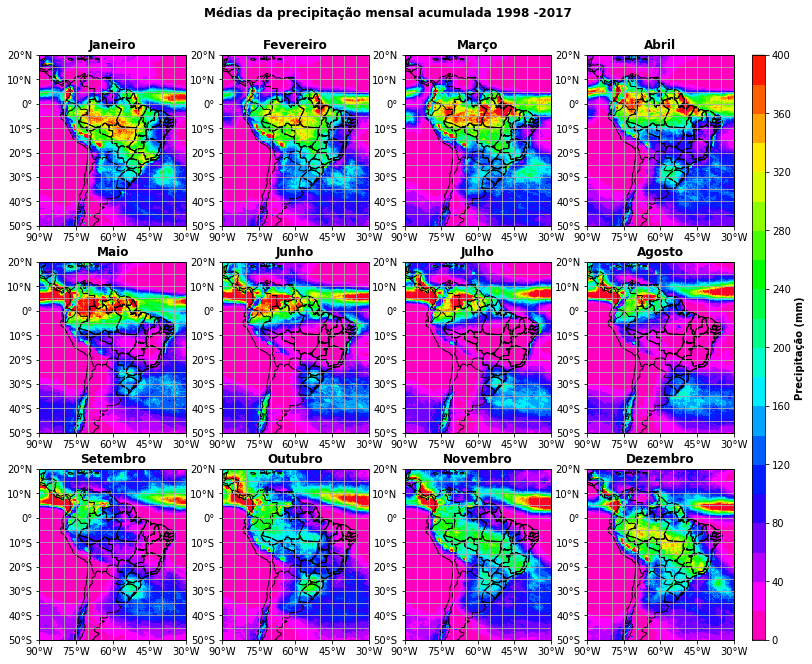

In [13]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 11))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(3, 4),
                axes_pad=0.5,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, -50, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-50, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-50, 25, 5))        
   
    # Plot data on these maps.
    p = DA_mon_mm[index].plot(
        ax=axis,
        vmin=0,
        vmax=400,
        levels=np.arange(0, 420, 20),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Precipitação (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 440, 40))        
plt.suptitle("Médias da precipitação mensal acumulada 1998 -2017 ", weight="bold")
plt.subplots_adjust(top=0.975)    

# Save figures.
plt.savefig(fig_path + "precipitation_trmm_cum_mmeans_pt.jpg", dpi=200, bbox_inches="tight")

In [14]:
# Annual means.
DA_anu = DA_mon.resample(indexer={"time": "1YS"}).sum("time")

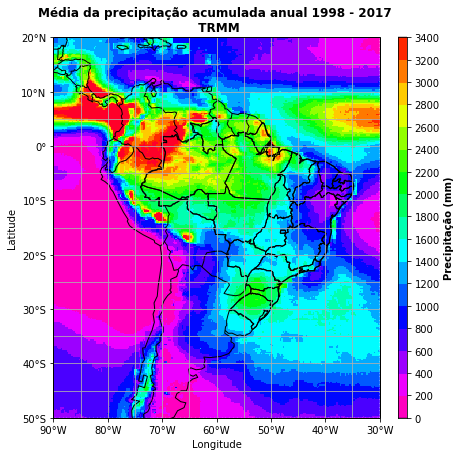

In [15]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, -50, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-50, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-50, 25, 5))

    # Plot data on this map.
    p = DA_anu.mean("time").plot(
        ax=axis,
        vmin=0,
        vmax=3500,
        levels=np.arange(0, 3400 + 200, 200),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Média da precipitação acumulada anual 1998 - 2017 \n TRMM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Precipitação (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 3400 + 100, 200))

# Save figures.
plt.savefig(fig_path + "precipitation_trmm_mean_pt.jpg", dpi=200, bbox_inches="tight")

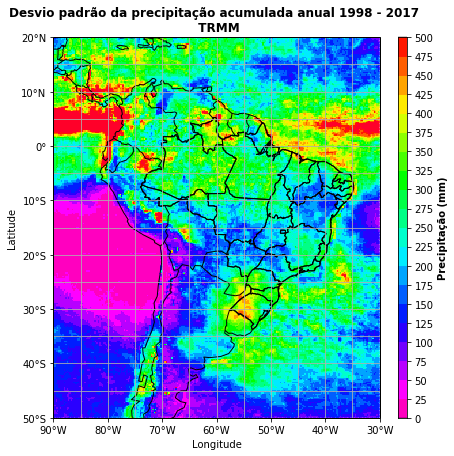

In [16]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, -50, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-50, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-50, 25, 5))

    # Plot data on this map.
    p = DA_anu.std("time").plot(
        ax=axis,
        vmin=0,
        vmax=500,
        levels=np.arange(0, 525, 25),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Desvio padrão da precipitação acumulada anual 1998 - 2017 \n TRMM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Precipitação (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 525, 25))

# Save figures.
plt.savefig(fig_path + "precipitation_trmm_std_pt.jpg", dpi=200, bbox_inches="tight")

## Empirical orthogonal functions analysis

In [17]:
%%time

solver = Eof(DA_mon)
EOFs = solver.eofs()
PCs = solver.pcs() 
PCTs = solver.varianceFraction()

CPU times: user 6.72 s, sys: 1.96 s, total: 8.68 s
Wall time: 5.24 s


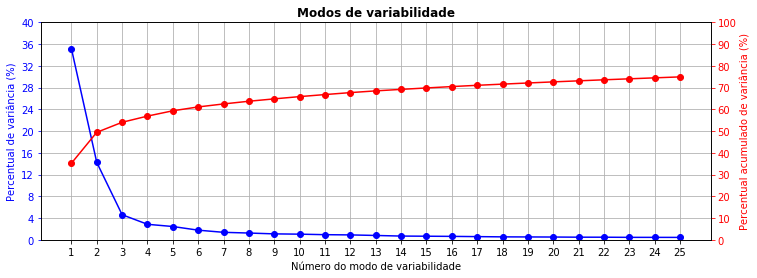

In [18]:
# Percentual of variance for N of the first modes.
N = 25
M = range(1, N + 1)
plt.figure(figsize=(12, 4))
plt.plot(M, PCTs.values[:N] * 100, "o-b")
plt.xlabel("Número do modo de variabilidade")
plt.ylabel("Percentual de variância (%)", color="blue")
plt.title("Modos de variabilidade", weight="bold")
plt.xticks(M)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_ylim((0, 40))
ax2.set_ylim((0, 100))
ax2.plot(M, np.cumsum(PCTs.values[:N] * 100), "o-r")
ax2.set_ylabel("Percentual acumulado de variância (%)", color="red")
ax1.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
ax1.set_yticks(np.linspace(0, ax1.get_yticks()[-1], 11))
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax1.grid();
plt.savefig(fig_path + "precipitation_trmm_modes_variances_pt.jpg", dpi=200, 
            bbox_inches="tight")

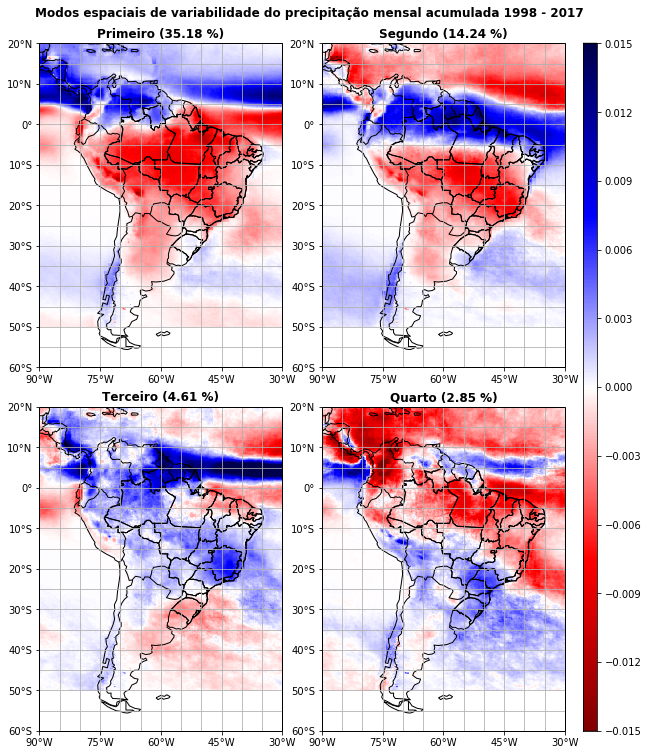

In [19]:
titles = ["Primeiro", "Segundo", "Terceiro", "Quarto"]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(10, 12.5))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.55,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = EOFs.sel(mode=index).plot(
        ax=axis,
        vmin=-0.015,
        vmax=0.015,
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(titles[index] + str(" (%.2f %%)" %(PCTs[index].values * 100)), 
                   weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-0.015, 0.018, 0.003))        
plt.suptitle("Modos espaciais de variabilidade do precipitação mensal acumulada " + \
             "1998 - 2017", weight="bold")
plt.subplots_adjust(top=0.99)    

# Save figures.
plt.savefig(fig_path + "precipitation_trmm_modes_spatial_pt.jpg", dpi=200, 
            bbox_inches="tight")

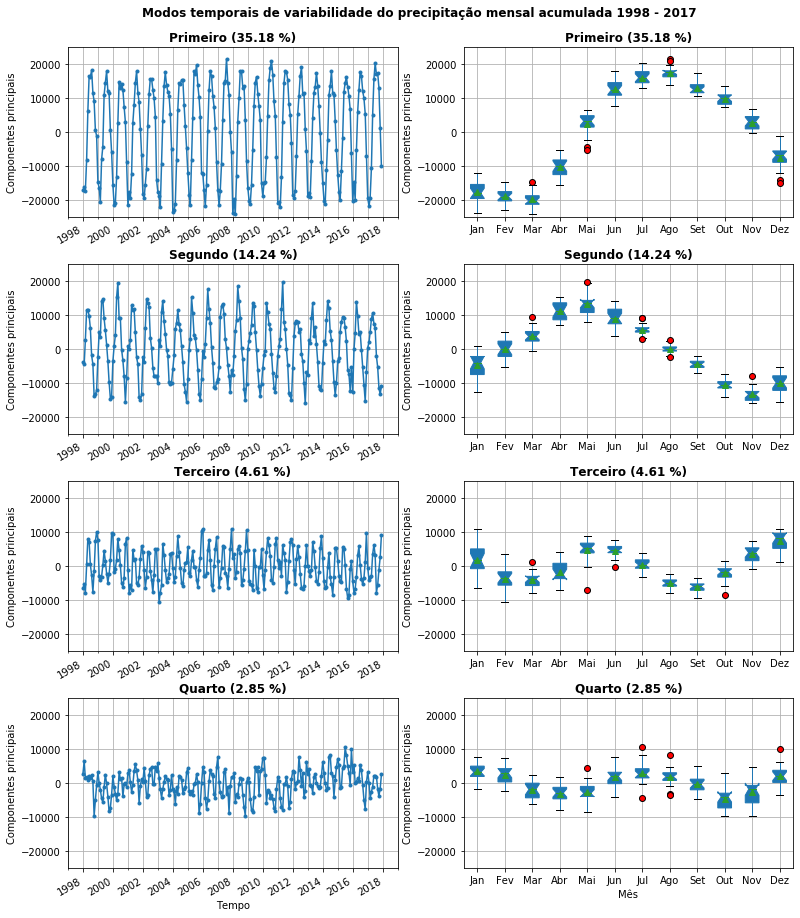

In [20]:
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

titles = ["Primeiro", "Segundo", "Terceiro", "Quarto"]
modes = [0, 0, 1, 1, 2, 2, 3, 3]
fig, axes = plt.subplots(4, 2, figsize=(13, 14))
axes = axes.flatten()

for index, ax, mode in zip(range(len(axes)), axes, modes):
    
    # Left column,
    if index % 2 == 0:
        
        PCs.sel(mode=mode).plot(marker=".", ax=ax)
        ax.set_xlim(pd.Timestamp("1997"), pd.Timestamp("2019"))
        ax.set_xticks(pd.date_range(start="1997", end="2019", freq="1YS"), minor=True)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)                             
        ax.grid(which="both")
        ax.set_title(titles[mode] + str(" (%.2f %%)" %(PCTs[mode].values * 100)), 
                     weight="bold")
        plt.suptitle("Modos temporais de variabilidade do precipitação mensal acumulada " + \
                     "1998 - 2017", weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("Componentes principais")
        ax.set_ylim((-25000, 25000))
    
    # Right hand side column.
    else:

        df = PCs.sel(mode=mode).to_dataframe()
        df = pd.pivot_table(df, index=df.index.year, columns=df.index.month, values="pcs") 
        df.columns = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", 
                      "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
        df.boxplot(ax=ax, patch_artist=True, showmeans=True, notch=True,
                   flierprops={"markerfacecolor": "red", "marker": "o"})
        ax.set_title(titles[mode] + str(" (%.2f %%)" %(PCTs[mode].values * 100)), 
                     weight="bold")
        ax.set_ylabel("Componentes principais")
        ax.set_ylim((-25000, 25000))

axes[6].set_xlabel("Tempo")
axes[7].set_xlabel("Mês")
plt.subplots_adjust(top=0.94, wspace=0.20, hspace=0.275) 

# Save figures.
plt.savefig(fig_path + "precipitation_trmm_modes_temporal_pt.jpg", dpi=200, 
            bbox_inches="tight")